Import delle librerie necessarie all'esperienza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Configurazione iniziale:

*MODIFICARE CON I VALORI VERI DEL PROPRIO APPARATO SPERIMENTALE!*

In [2]:
FOLDER = '300ml'                            # Cartella in cui trovo il .csv da analizzare
FILENAME = '0%UR.csv'                       # nome del file .csv da analizzare
FILE_PATH = os.path.join(FOLDER, FILENAME)
STEP_TEMPORALE_S = 1.0                      # modificare solo in caso di campionamento diverso da 1 al secondo


volume = 322    # del contenitore in ml
u_V = 3         # errore sul volume in ml

u_P = 0.1       # errore sulla pressione in kPa
u_T = 1         # errore sulla temperatura
u_UR = 3        # errore sull'umidità relativa

volume_silica = 14 # calcolaclo come m(g) / 0.7 g/ml
volume_ml = volume - volume_silica      # volume utile

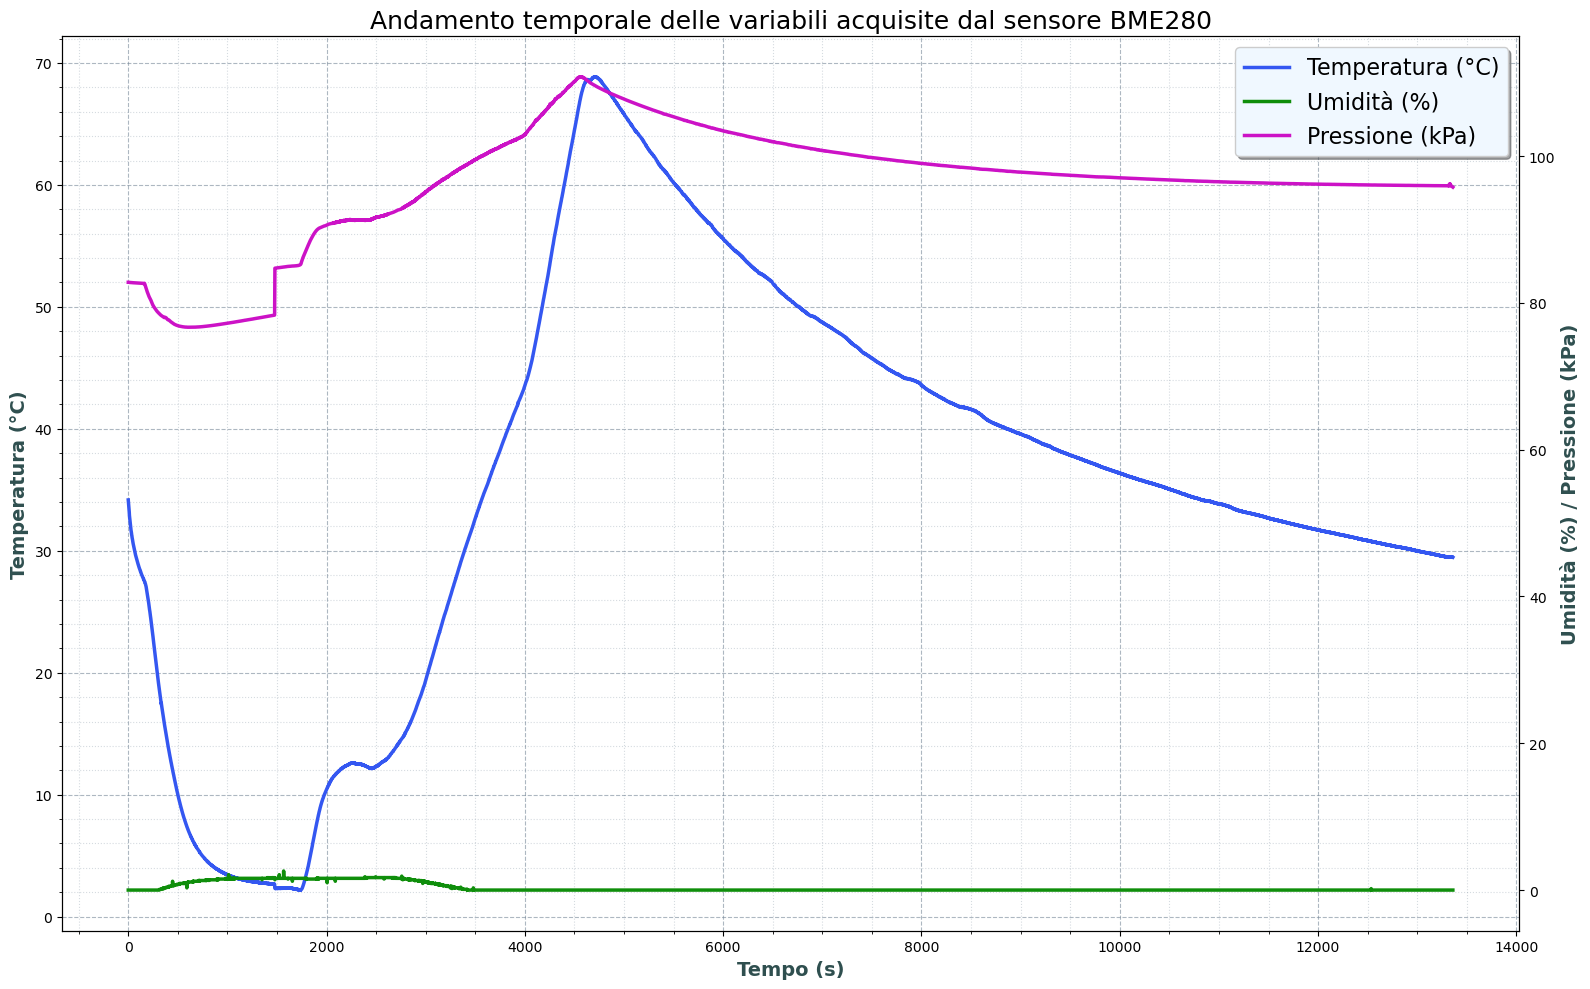

In [3]:
#  Caricamento Dati
if os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH)
else:
    raise FileNotFoundError(f"Il file {FILE_PATH} non è stato trovato.")

#  Parsing e Pulizia
df.columns = ['Timestamp_Raw', 'Temp_K', 'Hum_Pct', 'Pres_kPa']
regex_num = r'(\d+\.?\d*)' 

df['Temperatura'] = df['Temp_K'].astype(str).str.extract(regex_num).astype(float) - 273.15
df['Umidita'] = df['Hum_Pct'].astype(str).str.extract(regex_num).astype(float)
df['Pressione'] = df['Pres_kPa'].astype(str).str.extract(regex_num).astype(float) 
df.dropna(subset=['Temperatura', 'Umidita', 'Pressione'], inplace=True)
df['Tempo_Simulato_s'] = np.arange(len(df)) * STEP_TEMPORALE_S

# --- Plotting con Doppio Asse Y ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Primo Asse (Sinistro): Temperatura
line1, = ax1.plot(df['Tempo_Simulato_s'], df['Temperatura'], 
                  color="#3457F1", linewidth=2.5, label='Temperatura (°C)')
ax1.set_ylabel('Temperatura (°C)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Secondo Asse (Destro): Umidità e Pressione
ax2 = ax1.twinx()
line2, = ax2.plot(df['Tempo_Simulato_s'], df['Umidita'], 
                  color="#0F8E0B", linewidth=2.5, label='Umidità (%)')
line3, = ax2.plot(df['Tempo_Simulato_s'], df['Pressione'], 
                  color="#CC12C6", linewidth=2.5, label='Pressione (kPa)')
ax2.set_ylabel('Umidità (%) / Pressione (kPa)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Stile e Formattazione
ax1.set_xlabel('Tempo (s)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia (gestita dall'asse primario)
ax1.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899')
ax1.minorticks_on()
ax1.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')

# Unione delle Legende
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', frameon=True, shadow=True, fontsize=16, facecolor='#F0F8FF')

plt.title("Andamento temporale delle variabili acquisite dal sensore BME280", fontsize=18)
plt.tight_layout()
plt.show()

In [4]:
# eventuale cut dei dati se volessimo tralasciarne qualcuno per pulizia

mask_to_remove = (df['Tempo_Simulato_s'] <= 2000) | (df['Tempo_Simulato_s'] >= 60000)
df = df[~mask_to_remove].copy()

Calcolo delle moli con un algoritmo di interpolazione bilineare sui dati della tabella NIST per i valori di densità dell'aria al variare di umidità e temperatura

In [5]:
dati_tabella = {     
    0:   [1.292, 1.291, 1.290, 1.289, 1.288, 1.287],
    10:  [1.247, 1.246, 1.246, 1.245, 1.244, 1.243],
    20:  [1.204, 1.203, 1.202, 1.201, 1.200, 1.199],
    30:  [1.164, 1.163, 1.161, 1.160, 1.158, 1.156],
    40:  [1.127, 1.125, 1.122, 1.119, 1.116, 1.113],
    50:  [1.092, 1.089, 1.085, 1.081, 1.077, 1.073],
    60:  [1.060, 1.056, 1.051, 1.046, 1.041, 1.036],
    70:  [1.029, 1.024, 1.018, 1.012, 1.006, 1.000],
}
df_tabella = pd.DataFrame(dati_tabella, index=[0, 20, 40, 60, 80, 100])

#interpolazione bilineare per ricavare il dato più veritiero e concorde con i dati
from scipy.interpolate import RegularGridInterpolator

# Assicuriamoci che colonne e indici siano float ordinati
cols_t = np.array(df_tabella.columns, dtype=float)
idx_ur = np.array(df_tabella.index, dtype=float)
values = df_tabella.values  # Matrice (Righe=UR, Col=T)

# Interpolatore Bilineare (Scipy gestisce la griglia 2D)
interp_rho = RegularGridInterpolator((idx_ur, cols_t), values, bounds_error=False, fill_value=None)

def get_densita_interp(p_kpa, t_c, ur_pct):
    # Clamping per evitare errori fuori scala (0-100%)
    ur_pct = np.clip(ur_pct, idx_ur.min(), idx_ur.max())
    t_c = np.clip(t_c, cols_t.min(), cols_t.max())
    
    # Interpolazione
    rho_base = interp_rho([[ur_pct, t_c]])[0]
    
    # Scaling con pressione (Legge gas ideali: rho ~ P)
    return rho_base * (p_kpa / 101.325)

def calcola_moli(p_kpa, t_c, ur_pct, vol_ml):
    # Densità Interpolata
    rho = get_densita_interp(p_kpa, t_c, ur_pct)
    
    # Pressione Vapore (Magnus-Tetens) [kPa]
    p_sat_kpa = 0.6112 * np.exp((17.67 * t_c) / (t_c + 243.5))
    p_vapore = (ur_pct / 100.0) * p_sat_kpa
    
    # Frazione molare vapore
    x_v = p_vapore / p_kpa
    
    # Massa Molare Mix
    MM_aria = 0.02897
    MM_vapore = 0.018016
    mm_mix = (1 - x_v) * MM_aria + x_v * MM_vapore
    
    # Calcolo Moli
    moli = (rho * (vol_ml * 1e-6)) / mm_mix
    return moli


In [6]:
# Definiamo la funzione R(P, T, UR)

def calcola_R(p_kpa, t_c, ur_pct, vol_ml):
    # n dipende da P, T, UR, V
    moli = calcola_moli(p_kpa, t_c, ur_pct, vol_ml) 
    p_pa = p_kpa * 1000.0
    t_k = t_c + 273.15
    v_m3 = vol_ml * 1e-6
    return (p_pa * v_m3) / (moli * t_k)

# liste per il salvataggio dei dati
err_R_list = []
R_list = []

# ---Loop sui dati ---
for index, row in df.iterrows():
    # Valore nominale per ogni punto
    R_nom = calcola_R(row['Pressione'], row['Temperatura'], row['Umidita'], volume_ml)
    
    # Perturbazioni per il calcolo dei PESI (Errore Casuale/Puntuale)
    # Cioè calcoliamo la differenza tra il valore calcolato con i dati e il valore calcolato con i dati che sbagliano al massimo dell'errore
    dR_P = calcola_R(row['Pressione'] + u_P, row['Temperatura'], row['Umidita'], volume_ml) - R_nom
    dR_T = calcola_R(row['Pressione'], row['Temperatura'] + u_T, row['Umidita'], volume_ml) - R_nom
    dR_UR = calcola_R(row['Pressione'], row['Temperatura'], row['Umidita'] + u_UR, volume_ml) - R_nom
    dR_V = calcola_R(row['Pressione'], row['Temperatura'], row['Umidita'], volume_ml + u_V) - R_nom

    # Somma in quadratura delle variazioni puntuali
    incertezza_punto = np.sqrt(dR_P**2 + dR_T**2 + dR_UR**2 + dR_V**2)
    
    R_list.append(R_nom)
    err_R_list.append(incertezza_punto)

df_R = pd.DataFrame({
    'R': R_list,
    'Err_R': err_R_list
}, index=df.index)

# Media Pesata e Errore Statistico (scala con 1/sqrt(N))
weights = 1 / (df_R['Err_R'] ** 2)
weighted_mean_R = np.sum(df_R['R'] * weights) / np.sum(weights)
sigma_statistica = np.sqrt(1 / np.sum(weights)) # Errore interno

# Errore basato sulla Dispersione Reale (Errore esterno)
N = len(df_R)
w_variance = np.sum(weights * (df_R['R'] - weighted_mean_R)**2) / ((N - 1) * np.sum(weights))
sigma_dispersione = np.sqrt(w_variance)

# L'errore casuale finale è il massimo tra quello teorico e quello osservato
sigma_random_totale = max(sigma_statistica, sigma_dispersione)

# --- Calcolo Errore Sistematico (Accuratezza Strumentale) ---
# Questo errore NON scala con N. È il limite fisico dei sensori (Bias).
P_avg = df['Pressione'].mean()
T_avg = df['Temperatura'].mean()
UR_avg = df['Umidita'].mean()
R_avg_ref = calcola_R(P_avg, T_avg, UR_avg, volume_ml)

# Calcoliamo quanto si sposta la MEDIA se i sensori hanno un bias sistematico pari all'incertezza
syst_P = calcola_R(P_avg + u_P, T_avg, UR_avg, volume_ml) - R_avg_ref
syst_T = calcola_R(P_avg, T_avg + u_T, UR_avg, volume_ml) - R_avg_ref
syst_UR = calcola_R(P_avg, T_avg, UR_avg + u_UR, volume_ml) - R_avg_ref
syst_V = calcola_R(P_avg, T_avg, UR_avg, volume_ml + u_V) - R_avg_ref

# Somma in quadratura delle componenti sistematiche
sigma_sistematica = np.sqrt(syst_P**2 + syst_T**2 + syst_UR**2 + syst_V**2)

# --- Errore Totale Combinato ---
sigma_totale = np.sqrt(sigma_random_totale**2 + sigma_sistematica**2)

print(f"Media pesata di R: {weighted_mean_R:.4f} J/(mol·K)")
print(f"Errore Casuale (statistico, scala con N): {sigma_random_totale:.4e}")
print(f"Errore Sistematico (bias strumentale):    {sigma_sistematica:.4e}")
print(f"Errore Totale (da usare per compatibilità): {sigma_totale:.4e}")

R_valor_vero = 8.31446 
diff_sigma = abs(weighted_mean_R - R_valor_vero) / sigma_totale
print(f"Compatibilità col valor vero: {diff_sigma:.2f} σ")

Media pesata di R: 8.3129 J/(mol·K)
Errore Casuale (statistico, scala con N): 1.6821e-05
Errore Sistematico (bias strumentale):    4.8251e-03
Errore Totale (da usare per compatibilità): 4.8251e-03
Compatibilità col valor vero: 0.32 σ


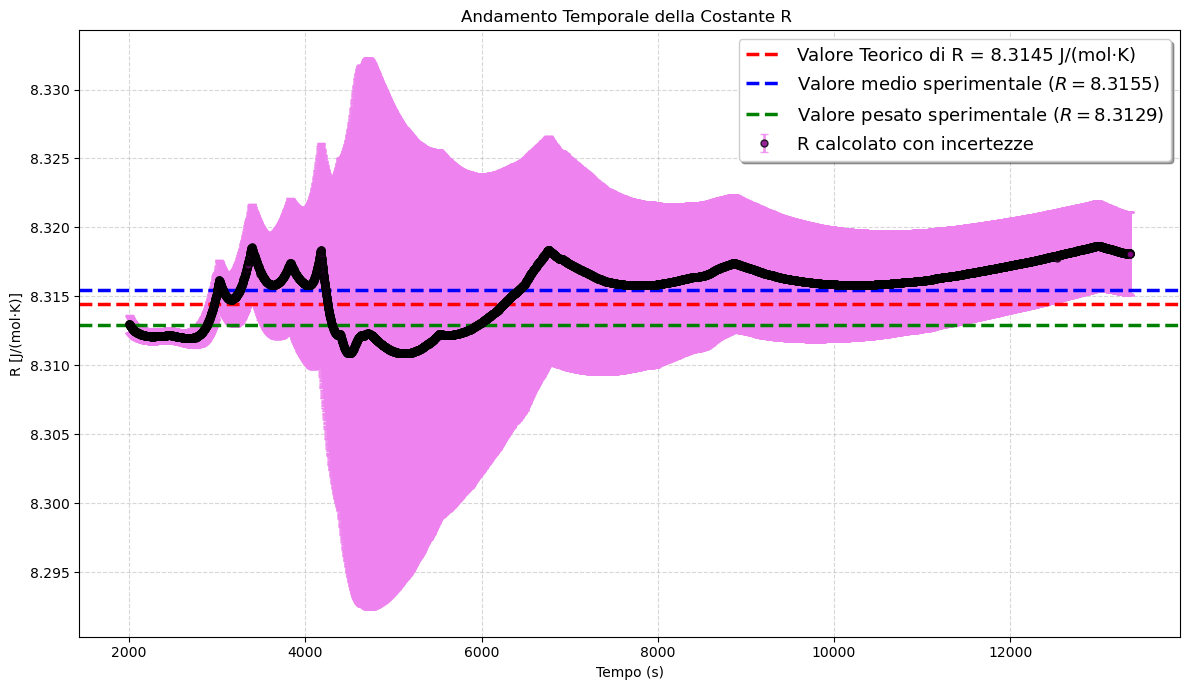

In [7]:
#plot di R con barre d'errore nel tempo

plt.figure(figsize=(12, 7))
plt.errorbar(df['Tempo_Simulato_s'] , df_R['R'], 
             yerr=df_R['Err_R'], 
             fmt='o', markersize=5, markerfacecolor='purple', markeredgecolor='black',
             ecolor='violet', elinewidth=2, capsize=3, alpha=0.8,
             label='R calcolato con incertezze')
plt.title(r'Andamento Temporale della Costante R ')
plt.xlabel('Tempo (s)')
plt.ylabel('R [J/(mol·K)]')

#LINEA ORIZZONTALE AL VALORE VERO DI R
plt.axhline(R_valor_vero, color='red', linestyle='dashed', linewidth=2.5, 
            label=f'Valore Teorico di R = {R_valor_vero:.4f} J/(mol·K)')
plt.axhline(df_R['R'].mean(), color='blue', linestyle='--', linewidth=2.5,
            label=f'Valore medio sperimentale ($R = {df_R["R"].mean():.4f}$)')
plt.axhline(weighted_mean_R, color='green', linestyle='--', linewidth=2.5, 
            label=f'Valore pesato sperimentale ($R = {weighted_mean_R:.4f}$)')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', frameon=True, shadow=True, fontsize = 13)
plt.tight_layout()
plt.show()  

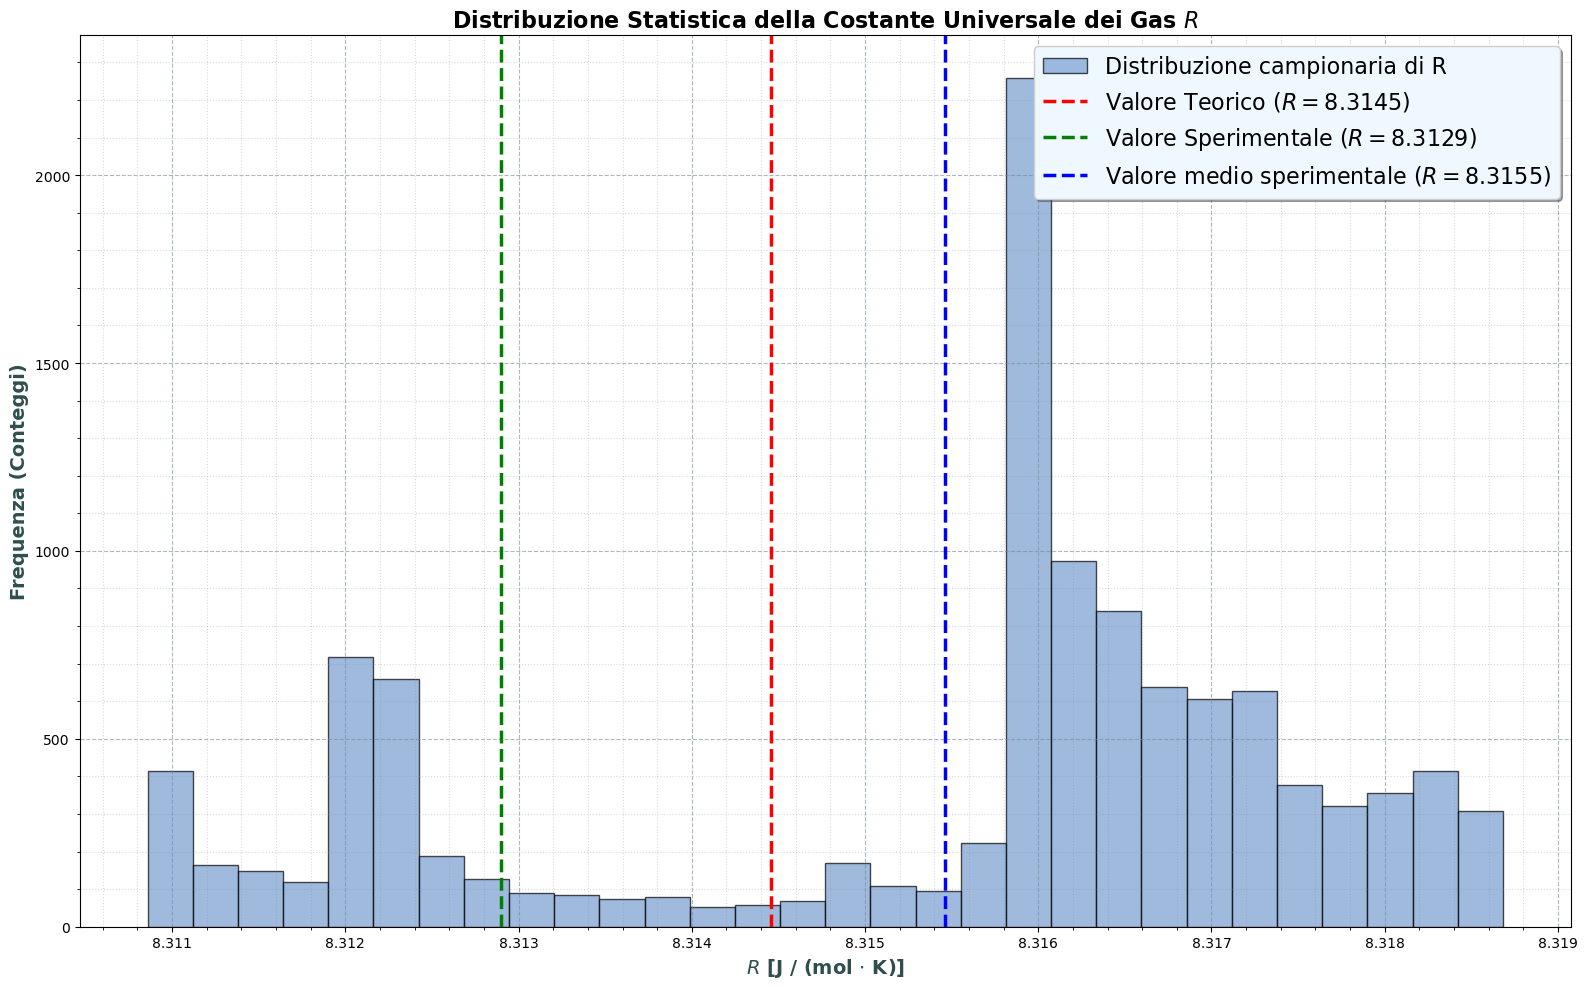

In [8]:
# istogramma dei valori di R

plt.figure(figsize=(16, 10))

counts, bins, patches = plt.hist(df_R['R'], bins='auto', 
                                 color='#789DD1', edgecolor='#000000', 
                                 alpha=0.7, label='Distribuzione campionaria di R')


plt.axvline(R_valor_vero, color='red', linestyle='--', linewidth=2.5, 
            label=f'Valore Teorico ($R = {R_valor_vero:.4f} $)')
plt.axvline(weighted_mean_R, color='green', linestyle='--', linewidth=2.5, 
            label=f'Valore Sperimentale ($R = {weighted_mean_R:.4f}$)')
plt.axvline(df_R['R'].mean(), color='blue', linestyle='--', linewidth=2.5,
            label=f'Valore medio sperimentale ($R = {df_R["R"].mean():.4f}$)')

# Formattazione e Label 
plt.title('Distribuzione Statistica della Costante Universale dei Gas $R$', fontsize=16, fontweight='bold')
plt.xlabel(r'$R$ [J / (mol $\cdot$ K)]', fontsize=14, fontweight='bold', color='#2F4F4F')
plt.ylabel('Frequenza (Conteggi)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia e Tick
plt.minorticks_on()
plt.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
plt.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda
plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=16, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()


Iniziamo i fit

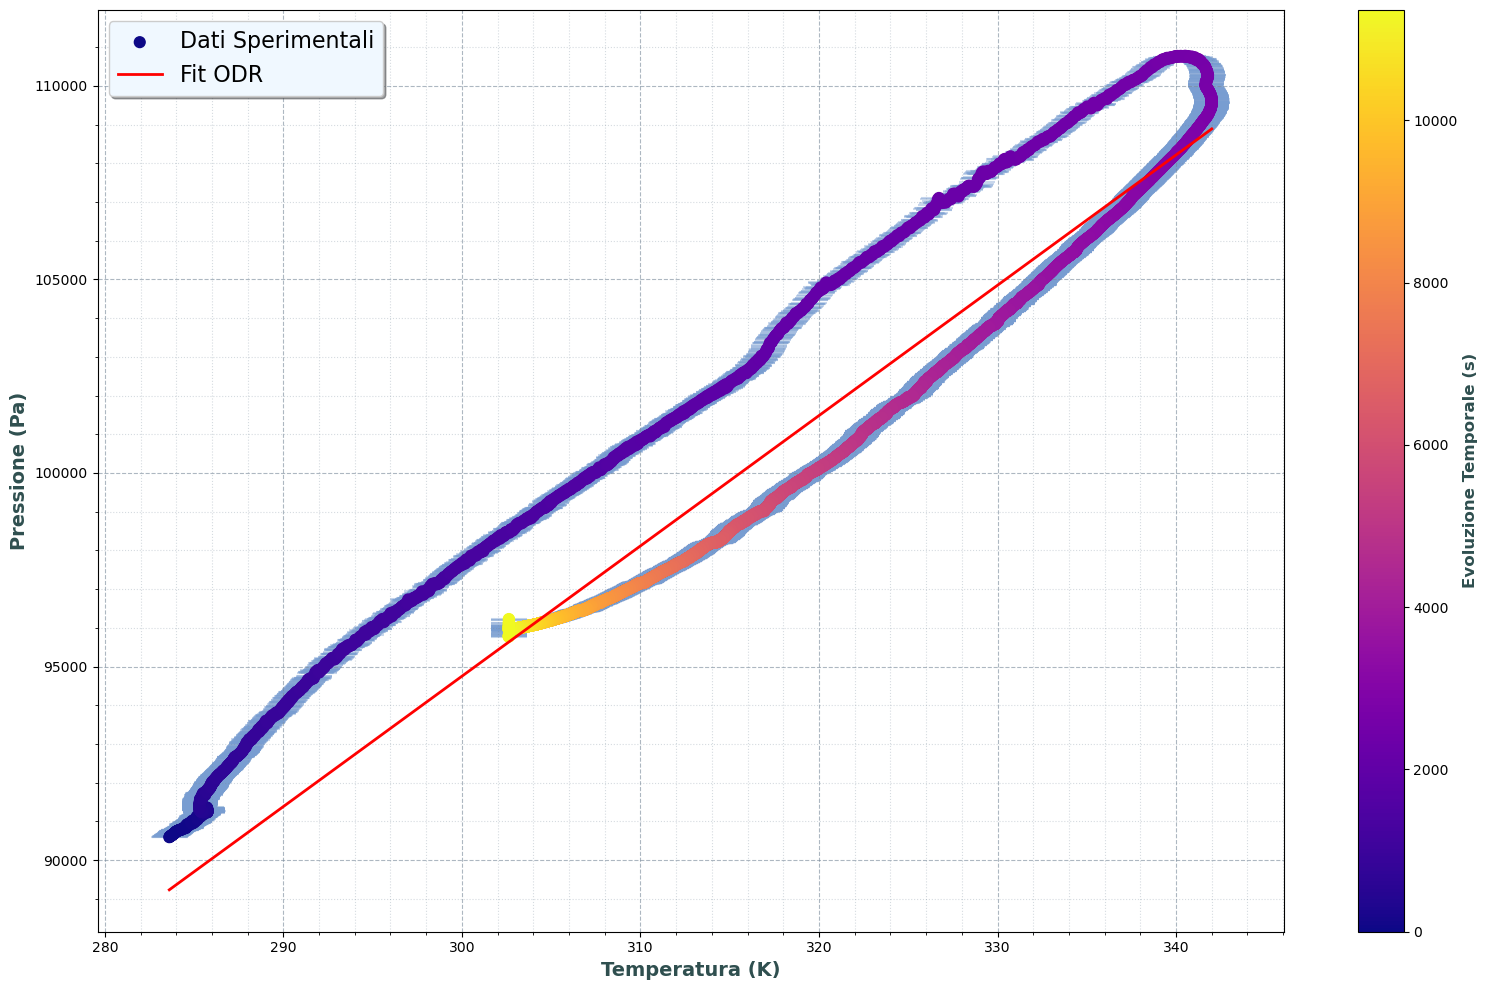

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)    : 336.6650 ± 0.2518 Pa/K
Intercetta Y (q): -6250.4428 ± 78.9071 Pa
------------------------------
Compatibilità con 0 della quota: 79.21 σ


In [9]:
from scipy import odr

# Preparazione Dati per il fit
df_PT = df[['Pressione', 'Temperatura']].copy()

# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values + 273.15  # K
y = df_PT['Pressione'].values * 1000.0    # Pa

# Creo un vettore per la mappatura temporale (indice progressivo)
time_evolution = np.arange(len(x))

# Configurazione ODR per il fit
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x, y, sx=1.0, sy=100.0) # Incertezze costanti
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 90])

# Eseguo il fit
output = my_odr.run()

# Incertezze e Covarianza
cov_matrix = output.cov_beta

# se Chi2 ridotto < 1, riscalo per ripristinare errori strumentali
if output.res_var < 1.0:
    print(f"Fit troppo 'pulito' (Chi2 ridotto = {output.res_var:.4f}). Riscalo covarianza.")
    cov_matrix = output.cov_beta / output.res_var

m, q = output.beta
sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Plotting 
fig, ax = plt.subplots(figsize=(16, 10))

# Barre d'errore (senza marcatori, solo linee)
ax.errorbar(x, y, xerr=1.0, yerr=100.0, fmt='none', 
             ecolor='#789DD1',    
             elinewidth=1.5,       
             alpha=0.4,            
             zorder=1 )

# Punti colorati con Colormap Plasma (Evoluzione Temporale)
sc = ax.scatter(x, y, c=time_evolution, cmap='plasma', 
                s=60,          
                alpha=1.0,     
                zorder=2, 
                label='Dati Sperimentali')

# Retta di fit ODR
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
ax.plot(x_fit, y_fit, color='red', linewidth=2, zorder=3, label='Fit ODR')

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale (s)', fontsize=12, fontweight='bold', color='#2F4F4F')

ax.set_xlabel('Temperatura (K)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia 
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda 
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=16, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)    : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)

real_q = 0
diff = abs(q - real_q)
comp = diff / sq
print(f"Compatibilità con 0 della quota: {comp:.2f} σ")


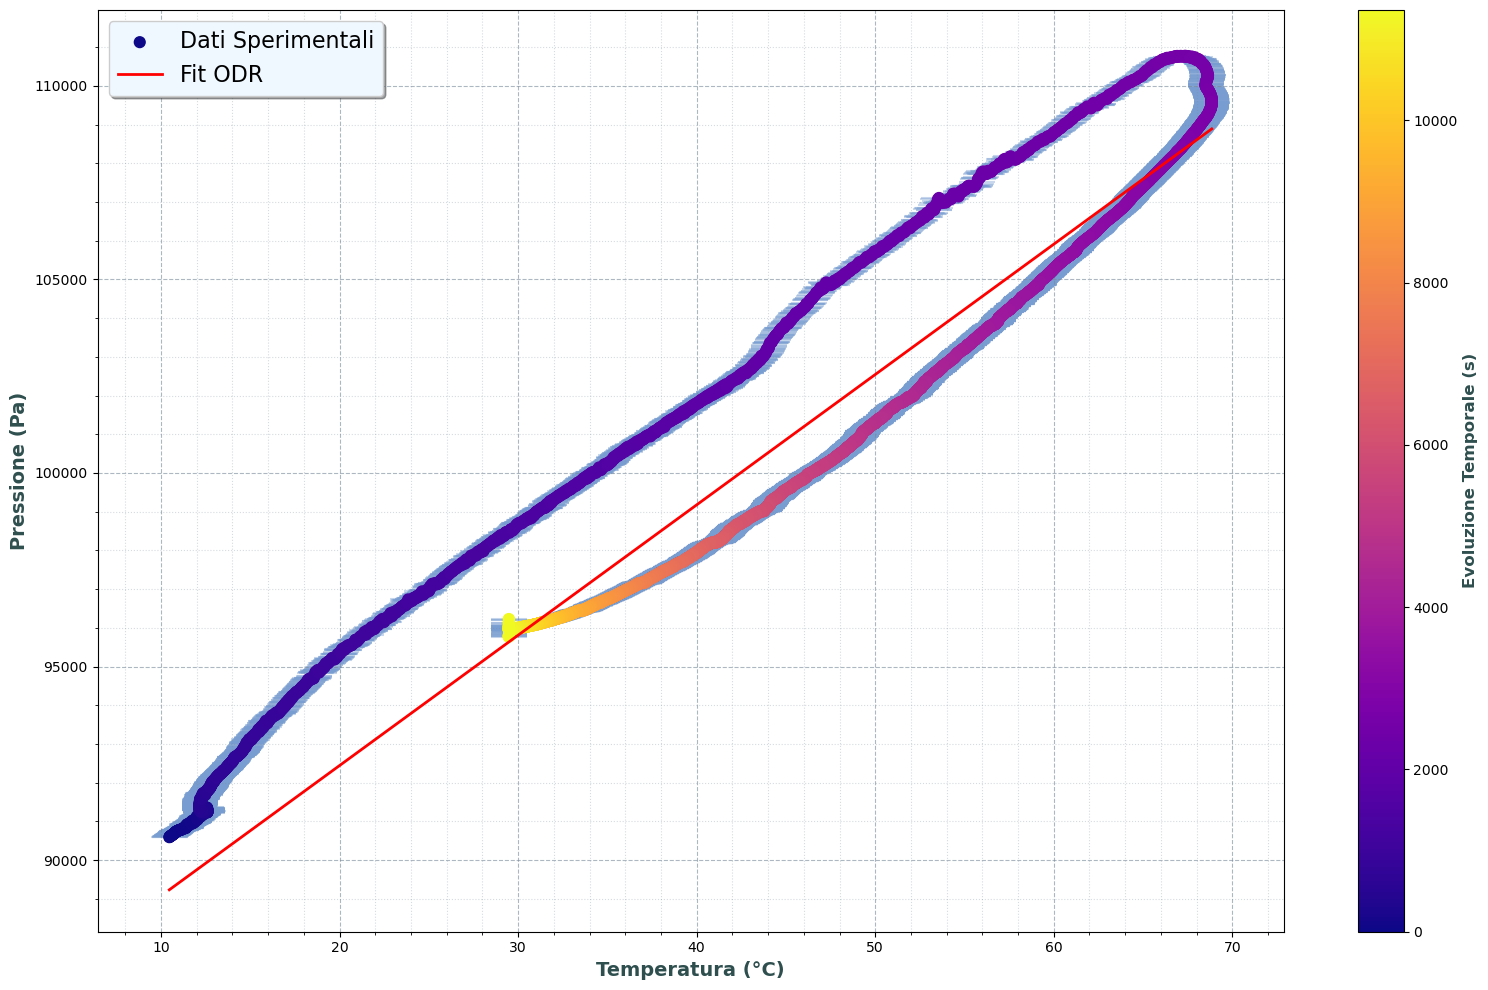

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)    : 336.6650 ± 0.2518 Pa/°C
Intercetta Y (q): 85709.5993 ± 10.5733 Pa
------------------------------
Temperatura a P=0:
T(P=0) = -254.58 ± 1.02 °C
------------------------------
Compatibilità con -273,15°C: 18.13 σ


In [10]:
# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values   # °C
y = df_PT['Pressione'].values * 1000.0   # Pa

# Creo un vettore per la mappatura temporale (indice progressivo)
time_evolution = np.arange(len(x))

# Configurazione ODR
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x, y, sx=1.0, sy=100.0) # Incertezze costanti
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 0])

# Eseguo il fit
output = my_odr.run()

# Analisi Incertezze e Covarianza
cov_matrix = output.cov_beta

# se Chi2 ridotto < 1, riscalo per ripristinare errori strumentali
if output.res_var < 1.0:
    print(f"Fit 'pulito' (Chi2 ridotto = {output.res_var:.4f}). Riscalo covarianza.")
    cov_matrix = output.cov_beta / output.res_var

m, q = output.beta
sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Calcolo T allo zero assoluto di pressione (Intercetta X)
T0 = -q / m

# Propagazione errore su T0
deriv_q = -1 / m
deriv_m = q / (m**2)
var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_matrix[0, 1]) # tanto è una matrice simmetrica
sT0 = np.sqrt(var_T0)

# Plotting 
fig, ax = plt.subplots(figsize=(16, 10))

# Barre d'errore
ax.errorbar(x, y, xerr=1.0, yerr=100.0, fmt='none', 
             ecolor='#789DD1',    
             elinewidth=1.5,       
             alpha=0.4,            
             zorder=1 )

# Punti colorati con Colormap Plasma (Evoluzione Temporale)
sc = ax.scatter(x, y, c=time_evolution, cmap='plasma', 
                s=60,          
                alpha=1.0,    
                zorder=2, 
                label='Dati Sperimentali')

# Retta di fit ODR
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
ax.plot(x_fit, y_fit, color='red', linewidth=2, zorder=3, label='Fit ODR')

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale (s)', fontsize=12, fontweight='bold', color='#2F4F4F')

# Formatting richiesto
ax.set_xlabel('Temperatura (°C)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda 
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=16, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

# Risultati Numerici
sigma_syst_T = 1.0 
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)    : {m:.4f} ± {sm:.4f} Pa/°C")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura a P=0:")
print(f"T(P=0) = {T0:.2f} ± {sT0_total:.2f} °C")
print("-" * 30)

zero_assoluto = -273.15
diff = abs(T0 - zero_assoluto)
comp = diff / sT0_total
print(f"Compatibilità con -273,15°C: {comp:.2f} σ")


Tento un algoritmo per far collassare l'ellise sul suo asse maggiore:

divido l'intero piano in quadratini, calcolo il valor medio di ogni quadratino sulla pressione
calcolo poi il valor medio di qudratini che stanno nella stessa colonna di temepratura



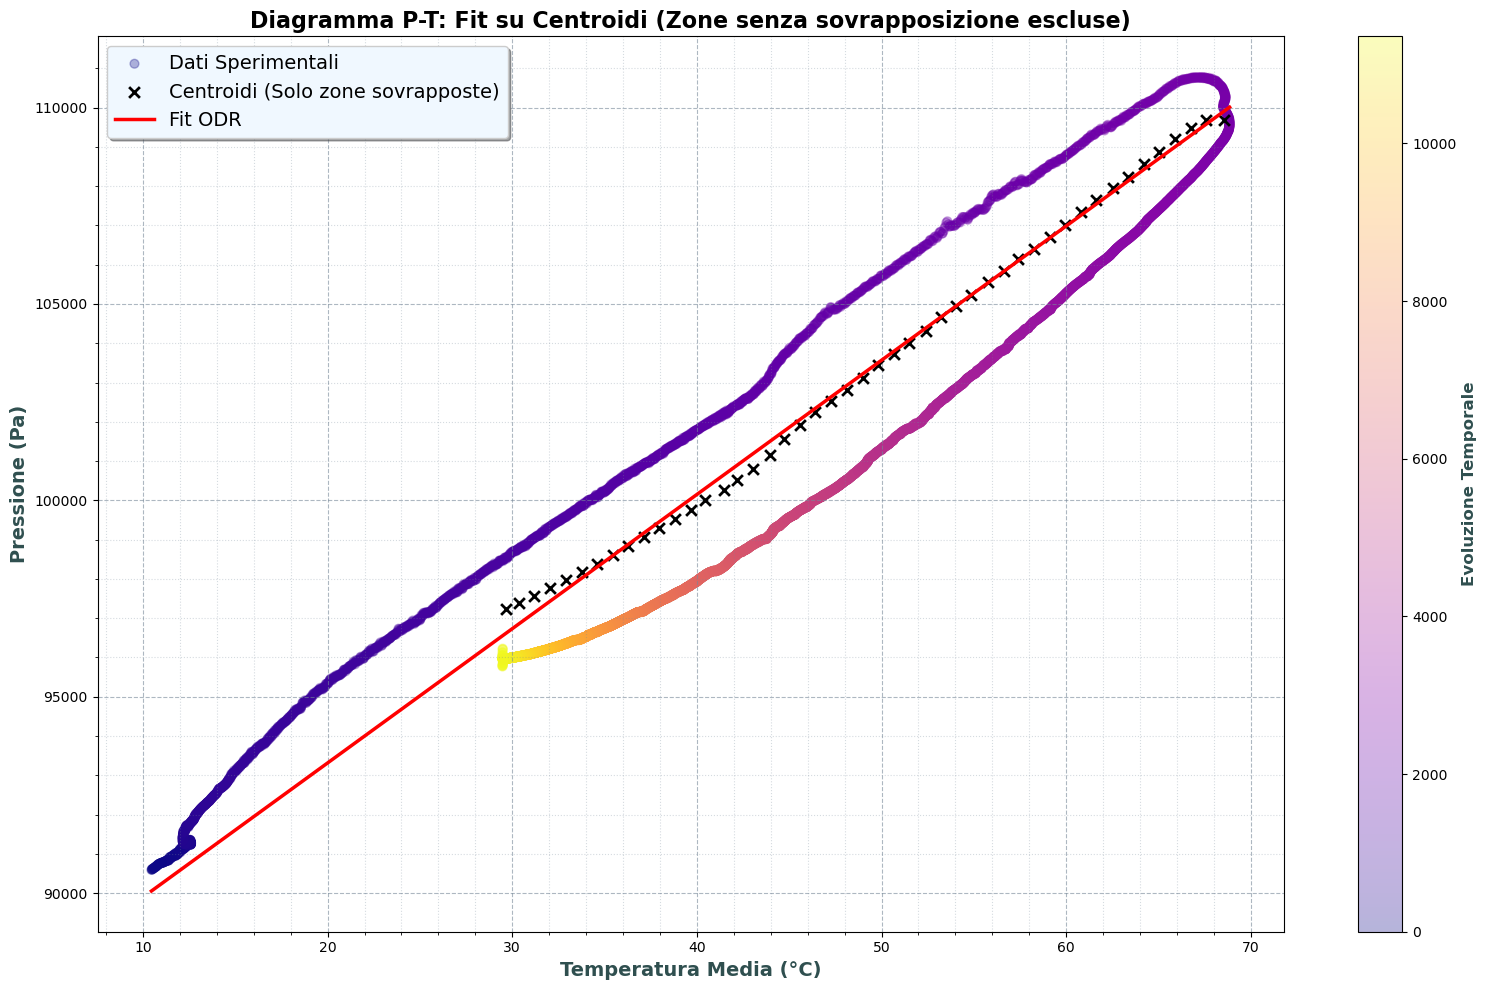

------------------------------
PARAMETRI FIT (Zone sovrapposte)
------------------------------
Pendenza (m)   : 341.7875 ± 7.2549 Pa/°C
Intercetta (q) : 86478.2817 ± 364.9016 Pa
------------------------------
Zero Assoluto  : -253.02 ± 6.49 °C
------------------------------
Compatibilità con -273,15°C : 3.10 σ


In [11]:
# Preparazione Dati e Separazione Rami
df_PT = df[['Pressione', 'Temperatura']].copy()

# Dati grezzi
x_all = df_PT['Temperatura'].values 
y_all = df_PT['Pressione'].values * 1000.0   
time_idx = np.arange(len(x_all))

# Trovo il punto di inversione termica (Massimo T)
idx_peak = np.argmax(x_all)

# Separo gli indici in due insiemi: Andata (Heating) e Ritorno (Cooling)
idx_heat = np.arange(0, idx_peak + 1)
idx_cool = np.arange(idx_peak + 1, len(x_all))

### Algoritmo di Binning con Verifica Bilaterale
num_bins = 70
bins = np.linspace(min(x_all), max(x_all), num_bins)

x_collapsed = []
y_collapsed = []

for i in range(len(bins) - 1):
    # Definizione bin corrente
    t_min, t_max = bins[i], bins[i+1]
    
    # Maschere per identificare i punti in questo bin
    mask_in_bin = (x_all >= t_min) & (x_all < t_max)
    
    # Intersezione: Punti nel bin E nel ramo riscaldamento
    mask_heat_bin = mask_in_bin & (np.isin(time_idx, idx_heat))
    
    # Intersezione: Punti nel bin E nel ramo raffreddamento
    mask_cool_bin = mask_in_bin & (np.isin(time_idx, idx_cool))
    
    # CONDIZIONE RIGIDA: Procedo solo se ENTRAMBI i rami hanno punti nel bin
    if np.sum(mask_heat_bin) > 0 and np.sum(mask_cool_bin) > 0:
        
        # Calcolo le medie separate (per evitare bias di densità)
        y_mean_heat = np.mean(y_all[mask_heat_bin])
        y_mean_cool = np.mean(y_all[mask_cool_bin])
        
        # La pressione media è la media aritmetica tra i due rami
        y_avg = (y_mean_heat + y_mean_cool) / 2.0
        
        # La temperatura x è il centro del bin (o la media dei punti, qui uso media punti)
        x_avg = np.mean(x_all[mask_in_bin])
        
        x_collapsed.append(x_avg)
        y_collapsed.append(y_avg)

# Converto in array per il fit
x_fit_data = np.array(x_collapsed)
y_fit_data = np.array(y_collapsed)

### Fit ODR sui dati filtrati e centrati
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x_fit_data, y_fit_data, sx=1.0, sy=100.0) 
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 90])
output = my_odr.run()

m, q = output.beta
cov_matrix = output.cov_beta
if output.res_var < 1.0:
    cov_matrix = output.cov_beta / output.res_var

sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Zero Assoluto
T0 = -q / m
# Errore T0
deriv_q = -1 / m
deriv_m = q / (m**2)
var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_matrix[0, 1])
sT0_total = np.sqrt(var_T0 + sigma_syst_T**2)

# Plotting
fig, ax = plt.subplots(figsize=(16, 10))

# A. Dati Originali (Background)
sc = ax.scatter(x_all, y_all, c=time_idx, cmap='plasma', 
                s=40, alpha=0.3, zorder=1, label='Dati Sperimentali')

# B. Dati "Collassati" (Media geometrica pura)
ax.scatter(x_fit_data, y_fit_data, color='black', marker='x', 
           s=60, linewidth=2, zorder=2, label='Centroidi (Solo zone sovrapposte)')

# C. Retta di Fit
x_line = np.linspace(min(x_all), max(x_all), 100)
y_line = m * x_line + q
ax.plot(x_line, y_line, color='red', linewidth=2.5, zorder=3, label='Fit ODR')

# Formatting
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale', fontsize=12, fontweight='bold', color='#2F4F4F')

ax.set_title('Diagramma P-T: Fit su Centroidi (Zone senza sovrapposizione escluse)', fontsize=16, fontweight='bold')
ax.set_xlabel('Temperatura Media (°C)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.legend(loc='best', frameon=True, shadow=True, fontsize=14, facecolor='#F0F8FF')

ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

plt.tight_layout()
plt.show()

### Risultati
print("-" * 30)
print("PARAMETRI FIT (Zone sovrapposte)")
print("-" * 30)
print(f"Pendenza (m)   : {m:.4f} ± {sm:.4f} Pa/°C")
print(f"Intercetta (q) : {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Zero Assoluto  : {T0:.2f} ± {sT0_total:.2f} °C")
print("-" * 30)


zero_assoluto = -273.15
diff = abs(T0 - zero_assoluto)
comp = diff / sT0_total
print(f"Compatibilità con -273,15°C : {comp:.2f} σ")

Provo anche a raggruppare i dati in gruppi di N_VALORI elementi

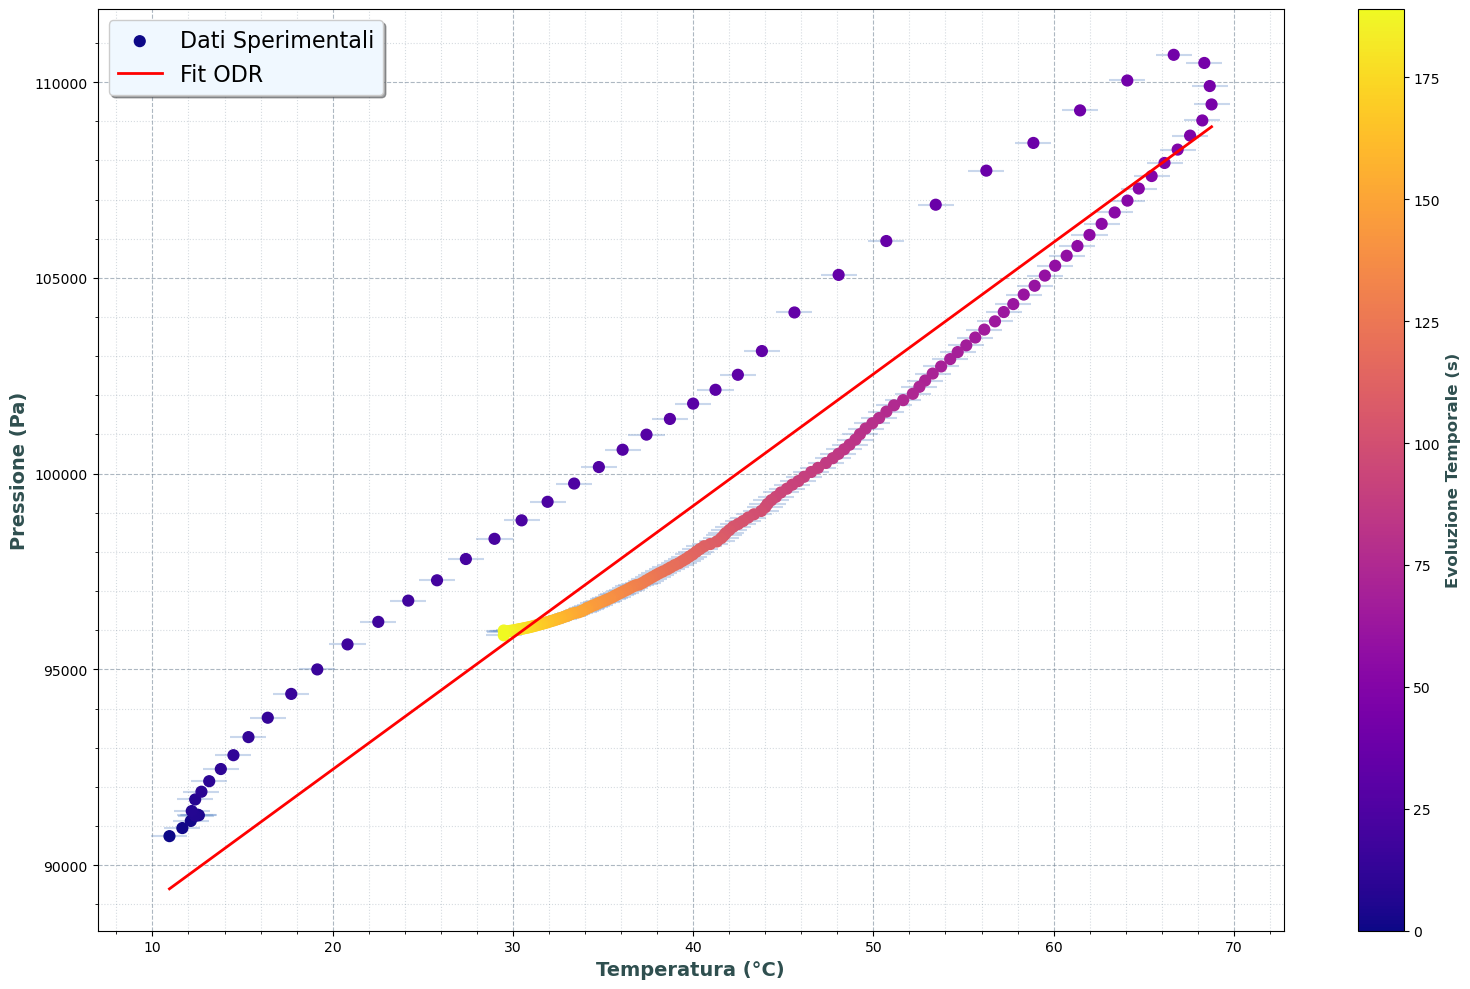

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)    : 336.6006 ± 1.9485 Pa/°C
Intercetta Y (q): 85712.9983 ± 81.7283 Pa
------------------------------
Temperatura a P=0:
T(P=0) = -254.64 ± 1.98 °C
------------------------------
Compatibilità con -273,15°C: 9.36 σ


In [12]:
### BINNING DEL DATASET

N_VALORI = 60  # Variabile esterna modificabile

# Crea colonne di "ID gruppo" tipo: 0, 0, 0, 0, 0, 1, 1, 1, 1, 1...
df['Gruppo_ID'] = np.arange(len(df)) // N_VALORI

# Calcolo della MEDIA 
# Raggruppa per l'ID creato e fa la media delle colonne
df_binned = df.groupby('Gruppo_ID')[['Temperatura', 'Pressione', 'Tempo_Simulato_s']].mean()

# Sovrascrivi df se vuoi usare direttamente questo per il fit successivo
df = df_binned.reset_index(drop=True)


# Definisco x (Temp) e y (Press)
x = df['Temperatura'].values   # °C
y = df['Pressione'].values * 1000.0    # Pa

# Creo un vettore per la mappatura temporale (indice progressivo)
time_evolution = np.arange(len(x))

# Configurazione ODR
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x, y, sx=1.0, sy=100.0) # Incertezze costanti
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 0])

# Eseguo il fit
output = my_odr.run()

# Analisi Incertezze e Covarianza
cov_matrix = output.cov_beta

# se Chi2 ridotto < 1, riscalo per ripristinare errori strumentali
if output.res_var < 1.0:
    print(f"Fit 'pulito' (Chi2 ridotto = {output.res_var:.4f}). Riscalo covarianza.")
    cov_matrix = output.cov_beta / output.res_var

m, q = output.beta
sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Calcolo T allo zero assoluto di pressione (Intercetta X)
T0 = -q / m

# Propagazione errore su T0
deriv_q = -1 / m
deriv_m = q / (m**2)
var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_matrix[0, 1])
sT0 = np.sqrt(var_T0) 

# Plotting 
fig, ax = plt.subplots(figsize=(16, 10))

# Barre d'errore
ax.errorbar(x, y, xerr=1.0, yerr=100.0, fmt='none', 
             ecolor='#789DD1',    
             elinewidth=1.5,       
             alpha=0.4,            
             zorder=1 )

# Punti colorati con Colormap Plasma (Evoluzione Temporale)
sc = ax.scatter(x, y, c=time_evolution, cmap='plasma', 
                s=60,          
                alpha=1.0,    
                zorder=2, 
                label='Dati Sperimentali')

# Retta di fit ODR
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
ax.plot(x_fit, y_fit, color='red', linewidth=2, zorder=3, label='Fit ODR')

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale (s)', fontsize=12, fontweight='bold', color='#2F4F4F')

# Formatting 
ax.set_xlabel('Temperatura (°C)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia 
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda 
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=16, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

# Risultati Numerici
sigma_syst_T = 1.0 
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)    : {m:.4f} ± {sm:.4f} Pa/°C")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura a P=0:")
print(f"T(P=0) = {T0:.2f} ± {sT0_total:.2f} °C")
print("-" * 30)

zero_assoluto = -273.15
diff = abs(T0 - zero_assoluto)
comp = diff / sT0_total
print(f"Compatibilità con -273,15°C: {comp:.2f} σ")
